In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
#import gresearch_crypto

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/g-research-crypto-forecasting/example_sample_submission.csv
/kaggle/input/g-research-crypto-forecasting/asset_details.csv
/kaggle/input/g-research-crypto-forecasting/example_test.csv
/kaggle/input/g-research-crypto-forecasting/train.csv
/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/__init__.py


In [2]:
pd.set_option("display.max_columns", None)

train = pd.read_csv('../input/g-research-crypto-forecasting/train.csv').set_index("timestamp")
assets = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv')
assets_order = pd.read_csv('../input/g-research-crypto-forecasting/supplemental_train.csv').Asset_ID[:14]

DEBUG=False

In [3]:
assets_order = dict((t,i) for i,t in enumerate(assets_order))

if DEBUG:
    train = train[20000000:]

train[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP','Target']] = \
train[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP','Target']].astype(np.float32)

train['Target'] = train['Target'].ffill()

In [4]:
VWAP_max = np.max(train[np.isfinite(train.VWAP)].VWAP)
VWAP_min = np.min(train[np.isfinite(train.VWAP)].VWAP)
print(VWAP_max, "\n", VWAP_min)

train['VWAP'] = np.nan_to_num(train.VWAP, posinf=VWAP_max, neginf=VWAP_min)

64799.82 
 -799.7471


In [5]:
def add_features(df):
    df['Upper_Shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
    df['Lower_Shadow'] = np.minimum(df['Close'], df['Open']) - df['Low']
    
    df['spread'] = df['High'] - df['Low']
    df['mean_trade'] = df['Volume']/df['Count']
    df['log_price_change'] = np.log(df['Close']/df['Open'])
    return df

In [6]:
train=add_features(train)
train.shape

(24236806, 14)

In [7]:
scale_features = train.columns.drop(['Asset_ID','Target'])
RS = RobustScaler()
train[scale_features] = RS.fit_transform(train[scale_features])

In [8]:
ind = train.index.unique()

def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.ffill().bfill()
    return df

train=train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
train.shape

/tmp/ipykernel_938/3927395060.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train=train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()


(27397440, 14)

In [9]:
df = train[['Asset_ID', 'Target']].copy()

times = dict((t,i) for i,t in enumerate(df.index.unique()))
df['id'] = df.index.map(times)
df['id'] = df['id'].astype(str) + '_' + df['Asset_ID'].astype(str)
ids = df.id.copy()

del df

In [10]:
train['group_num'] = train.index.map(times)
train = train.dropna(subset=['group_num'])
train['group_num'] = train['group_num'].astype('int')

train['id'] = train['group_num'].astype(str) + '_' + train['Asset_ID'].astype(str)

train['is_real'] = train.id.isin(ids)*1
train = train.drop('id', axis=1)

features = train.columns.drop(['Asset_ID','group_num','is_real'])
train.loc[train.is_real==0, features]=0

train['asset_order'] = train.Asset_ID.map(assets_order) 
train=train.sort_values(by=['group_num', 'asset_order'])
train.head(20)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Upper_Shadow,Lower_Shadow,spread,mean_trade,log_price_change,group_num,is_real,asset_order
timestamp,,,,,,,,,,,,,,,,,
1514764860,3,-0.237624,-0.061366,-0.061352,-0.061375,-0.061369,1.139151,-0.061361,-0.004612,-0.033876,-0.040011,-0.046746,2.612662,0.000000,0,1,0
1514764860,2,-0.118812,10.333434,10.414218,10.268881,10.324790,-0.046993,10.318357,-0.004218,68.918289,57.191864,50.716251,-0.027416,-1.069874,0,1,1
1514764860,0,-0.292079,-0.025190,-0.025248,-0.025128,-0.025193,-0.044815,-0.025186,-0.014399,-0.036854,-0.040011,-0.047932,-0.007496,0.000000,0,1,2
1514764860,1,0.816832,60.457150,61.124634,59.836346,60.523060,-0.046540,60.421989,-0.014643,492.229980,554.509277,416.621704,-0.027866,1.382319,0,1,3
1514764860,4,-0.267327,-0.062491,-0.062479,-0.062503,-0.062494,7.026424,-0.062487,0.006126,-0.036854,-0.040004,-0.047930,25.155483,0.000000,0,1,4
1514764860,5,-0.158416,-0.028997,-0.029048,-0.028956,-0.029009,0.196317,-0.029002,-0.013922,-0.036854,-0.037060,-0.044457,0.243421,-0.333478,0,1,5
1514764860,7,-0.292079,0.050880,0.050681,0.050891,0.050689,-0.043243,0.050759,-0.008264,-0.036854,-0.030171,0.007193,0.003700,-2.120515,0,1,6
1514764860,6,0.539604,3.167073,3.194698,3.148092,3.167987,-0.035329,3.169446,-0.004809,22.504492,18.957743,16.118418,-0.025500,0.354548,0,1,7
1514764860,8,-0.217822,-0.052594,-0.052601,-0.052596,-0.052607,-0.007371,-0.052599,0.001105,-0.036553,-0.040011,-0.045176,0.043741,-1.240933,0,1,8


In [11]:
targets = train['Target'].to_numpy()
#targets = np.expand_dims(targets, axis=1)

features = train.columns.drop(['Asset_ID', 'Target', 'group_num','is_real'])
train = train[features]

train=np.array(train)
train.shape

(27397440, 13)

In [12]:
class SampleGenerator(torch.utils.data.Dataset):
    def __init__(self, x_set, y_set, batch_size, length):
        self.x, self.y = x_set, y_set[:,np.newaxis] 
        self.batch_size = batch_size
        self.length = length
        self.size = len(x_set)

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = []
        batch_y = []
        for i in range(self.batch_size):
            start_ind = self.batch_size * idx + i
            end_ind = start_ind + self.length
            if end_ind <= self.size:
                batch_x.append(self.x[start_ind:end_ind])
                batch_y.append(self.y[end_ind - 1])

        return torch.tensor(np.array(batch_x)), torch.tensor(np.array(batch_y))

In [13]:
X_train, X_test = train[:-len(train)//10], train[-len(train)//10:]
y_train, y_test = targets[:-len(train)//10], targets[-len(train)//10:]

In [14]:
Batch_size = 2**12
Input_size = 13  # Input feature size
Hidden_size = 64  # Hidden state size
Output_size = 32
Train_window=15

train_generator = SampleGenerator(X_train, y_train, length=Train_window, batch_size=Batch_size)
val_generator = SampleGenerator(X_test, y_test, length=Train_window, batch_size=Batch_size)

print(f'Sample shape: {train_generator[0][0].shape}')
print(f'Target shape: {train_generator[0][1].shape}')

Sample shape: torch.Size([4096, 15, 13])
Target shape: torch.Size([4096, 1])


In [15]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, train_window):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.seq_length = train_window

        self.lstm_1 = nn.LSTM(input_size, hidden_size,batch_first=True)
        self.lstm_2 = nn.LSTM(hidden_size, output_size,batch_first=True)
        self.fc = nn.Linear(output_size,1)

    def forward(self, input_seq):
        
        lstm_out_1, _ = self.lstm_1(input_seq)
        lstm_out_2, _ = self.lstm_2(lstm_out_1)
        output = self.fc(lstm_out_2[:,-1,:])  
        
        return output

Evaluate Functions

In [17]:
def correlation(y_pred, y_true):
    # Assuming y_pred and y_true are tensors
    return torch.corrcoef(torch.stack((y_pred, y_true),dim=0))
                          
def masked_cosine(y_true, y_pred):
    mask = (y_true != 0)  # Create a mask where non-zero values are True
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]

    # Calculate cosine similarity
    similarity = torch.nn.functional.cosine_similarity(y_true_masked, y_pred_masked, dim=0)

    return similarity


def masked_mse(y_true, y_pred):
    mask = (y_true != 0)  # Create a mask where non-zero values are True
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]

    # Calculate cosine similarity
    mse = torch.nn.functional.mse_loss(y_true_masked, y_pred_masked)

    return mse



def model_test(data):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    output = torch.tensor([]).to(device)
    target = torch.tensor([]).to(device)
    with torch.no_grad():
        for i in range(len(data)):
            input_seq = data[i][0].float().to(device) 
            if input_seq.shape[0]==0:
                break
            target = torch.cat((target,data[i][1].float().to(device)),0)
            #print(target.shape)
            output = torch.cat((output,model(input_seq)),0)
    corr=correlation(target.squeeze(1), output.squeeze(1))[0,1].item()
    mse=masked_mse(target,output)
    return corr,mse


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTM(Input_size, Hidden_size, Output_size,Train_window)
model.to(device) 
EPOCH=5
optimizer = optim.Adam(model.parameters(), lr=0.001)

MSE=[[],[]]
CORR=[[],[]]
for i in range(EPOCH):
    model.train()
    for idx in range(len(train_generator)):
        optimizer.zero_grad()
        input_seq = train_generator[idx][0].float().to(device) 
        if input_seq.shape[0]==0:
            break
        target = train_generator[idx][1].float().to(device) 
        output = model(input_seq)
        loss = masked_mse(target,output)
        loss.backward()
        optimizer.step()
    model.eval()
    corr_0,mse_0=model_test(train_generator)
    print(f"Epoch {i+1}, Train Correlation is {corr_0}, Mean Square Error is {mse_0}")
    corr_1,mse_1=model_test(val_generator)
    print(f"Epoch {i+1}, Test Correlation is {corr_1}, Mean Square Error is {mse_1}")
    MSE[0].append(mse_0)
    CORR[0].append(corr_0)
    MSE[1].append(mse_1)
    CORR[1].append(corr_1)


Epoch 1, Train Correlation is 0.03435390070080757, Mean Square Error is 3.262777318013832e-05
Epoch 1, Test Correlation is 0.00016610203601885587, Mean Square Error is 2.3918872102512978e-05
Epoch 2, Train Correlation is 0.01750701665878296, Mean Square Error is 3.2536074286326766e-05
Epoch 2, Test Correlation is 0.0034081614576280117, Mean Square Error is 2.4192879209294915e-05
Epoch 3, Train Correlation is 0.1005183607339859, Mean Square Error is 3.236956035834737e-05
Epoch 3, Test Correlation is 0.006633449345827103, Mean Square Error is 2.3960439648362808e-05
Epoch 4, Train Correlation is 0.08175571262836456, Mean Square Error is 3.237363125663251e-05
Epoch 4, Test Correlation is 0.010883426293730736, Mean Square Error is 2.3946464352775365e-05
Epoch 5, Train Correlation is 0.12228705734014511, Mean Square Error is 3.234134419471957e-05
Epoch 5, Test Correlation is 0.011347895488142967, Mean Square Error is 2.3955406504683197e-05


In [ ]:
for j in range(2):
    for i in range(EPOCH):
        MSE[j][i]=MSE[j][i].to('cpu')


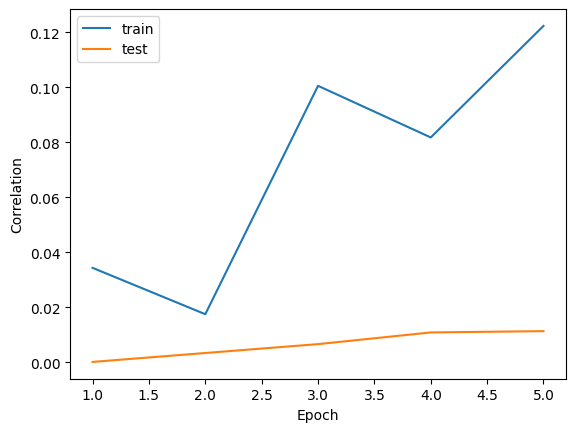

<Figure size 640x480 with 0 Axes>

In [27]:
epoch=[i+1 for i in range(EPOCH)]
plt.plot(epoch,CORR[0],label='train')
plt.plot(epoch,CORR[1],label='test')
plt.xlabel("Epoch")
plt.ylabel("Correlation")
plt.legend()
plt.show()
plt.savefig('./corr.png')

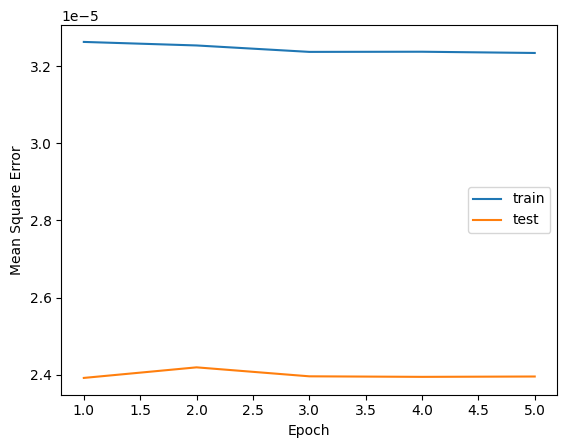

<Figure size 640x480 with 0 Axes>

In [28]:
epoch=[i+1 for i in range(EPOCH)]
plt.plot(epoch,MSE[0],label='train')
plt.plot(epoch,MSE[1],label='test')
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend()
plt.show()
plt.savefig('./mse.png')